## Decitabine treatment RNA-Seq 
### Time-series experiments

- In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the likelihood ratio test (LRT). 
- Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. 
- In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0).

(see DESeq2 [Time-series-experiments for more details](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments))



# Load data
### 1. Initiate R 


Load rpy2 to exert R within ipython notebook. 

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R 
library (GenomicFeatures)
library (tximport)
# library (BiocParallel)
# register(MulticoreParam(4))

### 2. Load annotations

In [6]:
!ls

session-2-deseq.ipynb


In [11]:
%%R 
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.basic.annotation.gtf.gz'
# GTF = 'gencode.v34.basic.annotation.gtf.gz'
txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



In [12]:
%%R 
k <- keys(txdb, keytype = "TXNAME")

In [13]:
%%R 
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



### 3. Load salmon quants 

In [21]:
%%R
# files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
files <- list.files(path='/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp/quants', pattern="quant.sf",full.names = TRUE, recursive=T)


In [22]:
%%R 
# names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)
names(files) <- gsub("/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp/quants/(\\S+)/quant.sf","\\1",files)

In [23]:
%%R 
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 



In [24]:
%%R 
txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

R[write to console]: transcripts missing from tx2gene: 121656

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



In [25]:
%%R 
saveRDS(txi.gene, 'txi.gene.rds')

### 4. Define the sample sheet

In [13]:
%%R 
colnames(txi$abundance)

 [1] "120h_DMSO_rep1"    "120h_DMSO_rep2"    "120h_treated_rep1"
 [4] "120h_treated_rep2" "6h_DMSO_rep1"      "6h_DMSO_rep2"     
 [7] "6h_treated_rep1"   "6h_treated_rep2"   "72h_DMSO_rep1"    
[10] "72h_DMSO_rep2"     "72h_treated_rep1"  "72h_treated_rep2" 


In [16]:
%%R 
hours = c(rep('120h', 4), rep('6h',4), rep('72h',4))
hours

 [1] "120h" "120h" "120h" "120h" "6h"   "6h"   "6h"   "6h"   "72h"  "72h" 
[11] "72h"  "72h" 


In [17]:
%%R 
# meta 
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('120h',4),rep('6h',4),rep('72h',4))

colData <- data.frame(
    time=hours, 
    cond=treats, 
    sample_id=paste(hours, treats, sep='_'),
    row.names=colnames(txi$abundance))
colData

                  time    cond    sample_id
120h_DMSO_rep1    120h    DMSO    120h_DMSO
120h_DMSO_rep2    120h    DMSO    120h_DMSO
120h_treated_rep1 120h treated 120h_treated
120h_treated_rep2 120h treated 120h_treated
6h_DMSO_rep1        6h    DMSO      6h_DMSO
6h_DMSO_rep2        6h    DMSO      6h_DMSO
6h_treated_rep1     6h treated   6h_treated
6h_treated_rep2     6h treated   6h_treated
72h_DMSO_rep1      72h    DMSO     72h_DMSO
72h_DMSO_rep2      72h    DMSO     72h_DMSO
72h_treated_rep1   72h treated  72h_treated
72h_treated_rep2   72h treated  72h_treated


# Quality control 

### 1. Make DESeq2 object 

In [19]:
%%R 
library(DESeq2)

In [20]:
%%R
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond + time )

R[write to console]: using counts and average transcript lengths from tximport



In [21]:
%%R
nrow(dds0)

[1] 203027


In [24]:
%%R 
class (dds0)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"


### 2. Statistical test

Run deseq test 

In [25]:
%%R 
dds.pca <- DESeq(dds0)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



### 3. Principal component analysis
Use [plotPCA](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotPCA) function and `ggplot2`. 

In [33]:
%%R 
library(ggplot2)
library(ggrepel)

In [30]:
%%R 
plot_PCA <- function(vsd, colData=colData, gr=c('time', 'cond'), title=''){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(size = 2), alpha = 4/10) +
            geom_text_repel(aes(label = row.names(colData)),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position="none")
    return (pca)
}

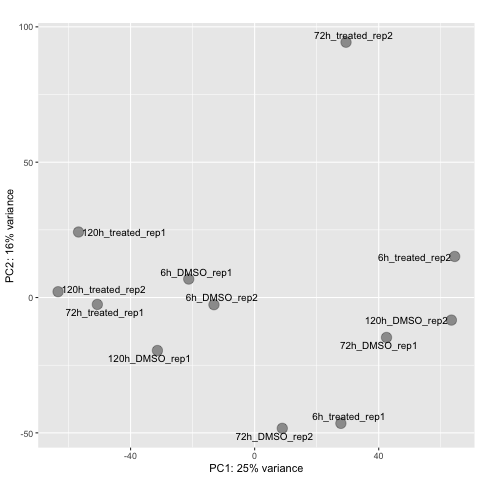

In [34]:
%%R 
pca = plot_PCA(vsd, colData)
pca

# Differential expression analysis

[Theory behind DESeq2](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#theory)!

In [1]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library (DESeq2)

Let's load the R Object from previous section, to continue our analysis. 

In [5]:
%%R 
txi.gene <- readRDS('txi.gene.rds')

### 1. Design linear model 


Here, we use `DESeqDataSetFromTximport` function from `DESeq2` package to take `salmon` gene level counts - previously imported into R using tximport. Then, we include condition table and a model design to build `DESeqDataSet` object. 

In [6]:
%%R 
colnames(txi.gene$abundance)

 [1] "120h_DMSO_rep1"    "120h_DMSO_rep2"    "120h_treated_rep1"
 [4] "120h_treated_rep2" "6h_DMSO_rep1"      "6h_DMSO_rep2"     
 [7] "6h_treated_rep1"   "6h_treated_rep2"   "72h_DMSO_rep1"    
[10] "72h_DMSO_rep2"     "72h_treated_rep1"  "72h_treated_rep2" 


In [10]:
%%R 
# meta 
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('120h',4),rep('6h',4),rep('72h',4))

colData <- data.frame(
    time=hours, 
    cond=treats, 
    row.names=colnames(txi.gene$abundance))
colData

                  time    cond
120h_DMSO_rep1    120h    DMSO
120h_DMSO_rep2    120h    DMSO
120h_treated_rep1 120h treated
120h_treated_rep2 120h treated
6h_DMSO_rep1        6h    DMSO
6h_DMSO_rep2        6h    DMSO
6h_treated_rep1     6h treated
6h_treated_rep2     6h treated
72h_DMSO_rep1      72h    DMSO
72h_DMSO_rep2      72h    DMSO
72h_treated_rep1   72h treated
72h_treated_rep2   72h treated


In [15]:
%%R 
dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond + time + cond:time)

dds$time <- relevel(dds$time, ref="6h")

R[write to console]: using counts and average transcript lengths from tximport



In [16]:
%%R 
class (dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"


What's going on behind the scene when you design your model as `~cond + time + cond:time`?!

In [17]:
%%R 
model.matrix (~cond + time + cond:time, colData)[,2:6]

                  condtreated time6h time72h condtreated:time6h
120h_DMSO_rep1              0      0       0                  0
120h_DMSO_rep2              0      0       0                  0
120h_treated_rep1           1      0       0                  0
120h_treated_rep2           1      0       0                  0
6h_DMSO_rep1                0      1       0                  0
6h_DMSO_rep2                0      1       0                  0
6h_treated_rep1             1      1       0                  1
6h_treated_rep2             1      1       0                  1
72h_DMSO_rep1               0      0       1                  0
72h_DMSO_rep2               0      0       1                  0
72h_treated_rep1            1      0       1                  0
72h_treated_rep2            1      0       1                  0
                  condtreated:time72h
120h_DMSO_rep1                      0
120h_DMSO_rep2                      0
120h_treated_rep1                   0
120h_treated_rep

### 2. Run DESeq statistical test 

As suggested [here](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments), we use **likelihood ratio test** while we are working with time-series-experiments. 

In [18]:
%%R 
dds <- DESeq(dds, test="LRT", reduced=~1)

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [19]:
%%R 
resultsNames(dds)

[1] "Intercept"            "cond_treated_vs_DMSO" "time_120h_vs_6h"     
[4] "time_72h_vs_6h"       "condtreated.time120h" "condtreated.time72h" 


In [21]:
%%R 
# contrast design: treatment at 120h vs dmso at 120h
res = results(dds, contrast=list('cond_treated_vs_DMSO', 'condtreated.time120h'))

### 3. Add gene name column and write results into a text file

Why not using Excel?! see [this paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-1044-7)!

Ok! Let's add gene names for each ensemble ids to make it readable. 

In [27]:
%%R 
library (GenomicFeatures)
library (tidyverse)

Absolute path to the annotation file

In [28]:
%%R
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.basic.annotation.gtf.gz'
# GTF = 'gencode.v34.basic.annotation.gtf.gz'

In [29]:
%%R 
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% 
    data.frame %>% 
    column_to_rownames('gene_id') %>% 
    dplyr::select('gene_name')

Add gene name column:

In [39]:
%%R 
res = res %>%
    data.frame %>% 
    add_column(name=gene2name[rownames(dds),])

In [ ]:
%%R 
write.table(res,'results_at_120h.txt', sep="\t", quote=FALSE, col=FALSE, row=FALSE)

### 4. Get normalized counts 

In [24]:
%%R 
ncu <- counts(dds, normalized=TRUE) 
head(ncu )

                   120h_DMSO_rep1 120h_DMSO_rep2 120h_treated_rep1
ENSG00000000003.15       8.485357       13.34196         18.526391
ENSG00000000419.12    1702.529959     1909.34179       1195.855818
ENSG00000000457.14     154.842155      147.35534        170.500796
ENSG00000000460.17     236.656253       21.46369          8.952925
ENSG00000000938.13     140.012703      135.26403        944.259831
ENSG00000000971.16       0.000000        0.00000          1.089788
                   120h_treated_rep2 6h_DMSO_rep1 6h_DMSO_rep2 6h_treated_rep1
ENSG00000000003.15         17.803727     10.24476       9.2117        9.160149
ENSG00000000419.12       1064.564069   2332.84226    2113.2739     2248.394484
ENSG00000000457.14        190.812696    133.32733     154.0523      164.564302
ENSG00000000460.17        235.853591    340.61807     298.0294      156.710574
ENSG00000000938.13        870.709096    134.06923     136.5650      211.136180
ENSG00000000971.16          2.094556      0.00000       0

In [ ]:
%%R 
write.table(ncu,'DE2norm.txt', sep="\t", quote=FALSE, col.names=row.names(colData))

# Data visualization

Here we use `ggplot2` package to draw [Volcano_plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)). 

In [32]:
%%R
library (ggplot2)
library (ggrepel)
# library (patchwork)

### 1. Define statistical significance threshold 

In [34]:
%%R 

lfc.cutoff  = 1
pval.cutoff = 0.05
title=''
x_min=-20
x_max=20


res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
res$sig <- relevel(res$sig, ref=TRUE)

### 2. Draw plot and include guides 

In [40]:
%%R
res = res %>% data.frame 
vol = res %>% ggplot(
    aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
    geom_point(aes(color = sig),alpha = 1/10) +
        # limit plot's axes
        xlim(c(x_min,x_max)) +
#         ylim(c(0,11)) +
        # draw guide lines 
        geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
        geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
        geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
        scale_color_manual(values = c("grey", "red")) +

        theme_bw() + 
        theme(legend.position="none") +
        ggtitle (title) + 
        # show few top gene names in the plot  
        geom_text_repel(
            data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
            aes(label = name),
            size = 3,
            box.padding = unit(0.35, "lines"),
            point.padding = unit(0.3, "lines")
        )

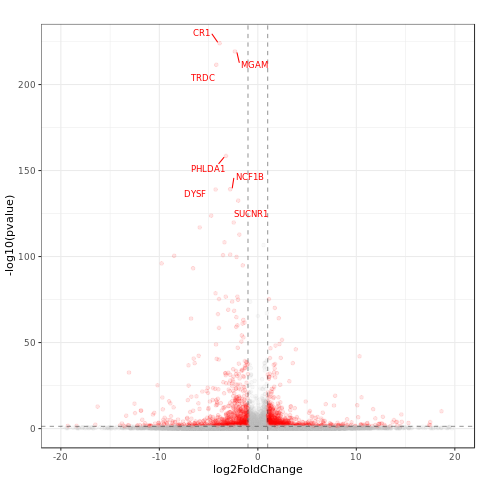

In [41]:
%%R 
vol

### 3. Save plot into file 

In [ ]:
%%R 
ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)

In [35]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.15.6

Matrix products: default
BLAS: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /Users/abearab/anaconda3/envs/renv/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggrepel_0.8.2               ggplot2_3.0.0              
 [3] DESeq2_1.20.0               SummarizedExperiment_1.10.1
 [5] DelayedArray_0.6.6          BiocParallel_1.14.2        
 [7] matrixStats_0.56.0          tximport_1.10.1            
 [9] GenomicFeatures_1.32.3      AnnotationDbi_1.42.1       
[11] Biobase_2.40.0              GenomicRanges_1.32.7       
[13] GenomeInfoDb_1.16.0         IRanges_2.14.12            
[15] S4Vectors_0.18.3